I have been working on other projects and have not thought about this project for a month. Need to re-familiarize myself with what has been done and what needs to be done. This notebook is an attempt just to remind myself what is going on.

In [2]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-09-15 
Git hash: ec5e4e30da99e64bf7cdc77a7333868aa6ba278e


In [3]:
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
ncbi = db['ncbi']
remap = db['remap']

In [4]:
# imports


In [5]:
# Number of runs
list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_flags': {'$exists': 1}
        }
    },
    {'$count': 'cnt'}
]))

[{'cnt': 35363}]

In [6]:
# Number of runs completed
list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_flags': 'complete'
        }
    },
    {'$count': 'cnt'}
]))

[{'cnt': 21228}]

In [7]:
# Number of "RNA-seq" runs 

# Get list of srx that look like RNA-seq
srxs = [x['srx'] for x in ncbi.aggregate([
    {
        '$match': {
            'sra.experiment.library_strategy': 'RNA-Seq'
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx'
        }
    }
])]
print('There are {:,} srx that are probably RNA-seq'.format(len(srxs)))

srrs = [x['srr'] for x in remap.aggregate([
    {
        '$match': {
            '_id': {'$in': srxs}
        }
    },
    {'$unwind': '$runs'},
    {
        '$project': {
            '_id': 0,
            'srr': '$runs.srr'
        }
    }
])]
print('There are {:,} srr that are probably RNA-seq.'.format(len(srrs)))

srrs_done = [x['srr'] for x in remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.srr': {'$in': srrs},
            'runs.pre_aln_flags': 'complete'
        }
    },
    {
        '$project': {
            '_id': 0,
            'srr': '$runs.srr'
        }
    }
])]
print('There are {:,} srr that are probably RNA-seq and have completed the pre-align workflow'.format(len(srrs_done)))

There are 11,804 srx that are probably RNA-seq
There are 15,689 srr that are probably RNA-seq.
There are 15,045 srr that are probably RNA-seq and have completed the pre-align workflow


In [8]:
# Why are the ones missing?
srrs_not_done = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.srr': {'$in': srrs},
            'runs.pre_aln_flags': {'$ne': 'complete'}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srr': '$runs.srr',
            'flags': '$runs.pre_aln_flags'
        }
    }
]))

In [9]:
# make list of srrs that need running
need_running = []
for x in srrs_not_done:
    if ('alignment_bad' not in x['flags']) and ('download_bad' not in x['flags']) and \
       ('abi_solid' not in x['flags']) and ('quality_scores_bad' not in x['flags']):
        need_running.append(x['srr'])
print('There are {:,} srrs that need run.'.format(len(need_running)))

There are 163 srrs that need run.


In [10]:
# Export a priority list
with open('../../data/priority.txt', 'w') as fh:
    fh.write('\n'.join(need_running))

In [44]:
jcounts = pd.DataFrame(list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_flags': 'complete'
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'jcount': '$runs.pre_aln_workflow.featurecounts.Assigned_Junction',
            'assigned': '$runs.pre_aln_workflow.featurecounts.Assigned',
            'prop_junc': {
                '$log10': {
                    '$add': [
                        {
                            '$divide': [
                                '$runs.pre_aln_workflow.featurecounts.Assigned_Junction',
                                '$runs.pre_aln_workflow.featurecounts.Assigned'
                            ]
                        },
                        1
                    ]
                }
                    
            }
        }
    }
])))


In [45]:
jcountsuntsnts.head()

,assigned,jcount,prop_junc,srr,srx
0,1003825,15039,0.006458,SRR5278103,SRX2581987
1,591224,106242,0.071771,SRR5251041,SRX2556775
2,134674,26199,0.077199,SRR5251040,SRX2556774
3,637926,126951,0.078821,SRR5251039,SRX2556773
4,491531,94518,0.076383,SRR5251038,SRX2556772


In [18]:
jcounts['log_prop'] = np.log10(jcounts.prop_junc + 1)

In [19]:
mask = jcounts.srr.isin(srrs_done)

In [40]:
jcounts.head()

,assigned,jcount,prop_junc,srr,srx,log_prop,class
0,1003825,15039,0.014982,SRR5278103,SRX2581987,0.006458,Unknown
1,591224,106242,0.179698,SRR5251041,SRX2556775,0.071771,RNA-Seq
2,134674,26199,0.194536,SRR5251040,SRX2556774,0.077199,RNA-Seq
3,637926,126951,0.199006,SRR5251039,SRX2556773,0.078821,RNA-Seq
4,491531,94518,0.192293,SRR5251038,SRX2556772,0.076383,RNA-Seq


In [14]:
import seaborn as sns

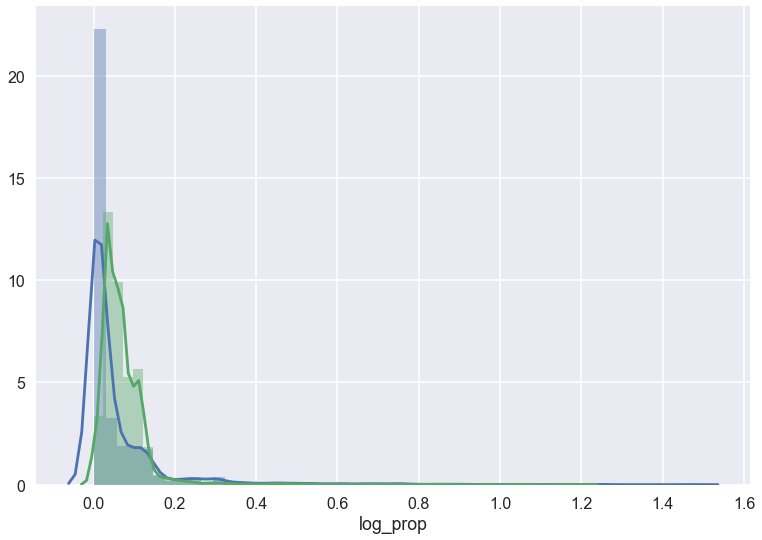

In [15]:
sns.distplot(jcounts[~mask].log_prop)
sns.distplot(jcounts[mask].log_prop)

In [20]:
jcounts.loc[mask, 'class'] = 'RNA-Seq'
jcounts.loc[~mask, 'class'] = 'Unknown'

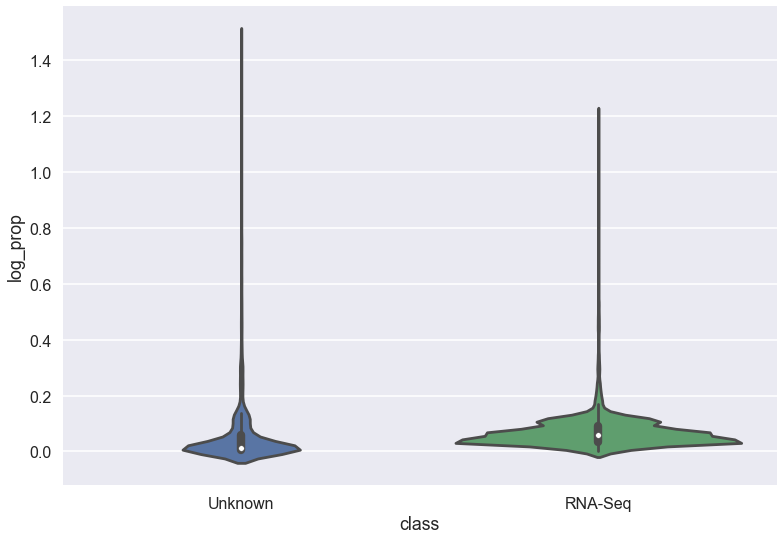

In [39]:
sns.violinplot(x='class', y='log_prop', data=jcounts, inner="box", scale="count")

In [95]:
jcounts.head()

,assigned,jcount,prop_junc,srr,srx
0,591224,106242,0.179698,SRR5251041,SRX2556775
1,134674,26199,0.194536,SRR5251040,SRX2556774
2,637926,126951,0.199006,SRR5251039,SRX2556773
3,491531,94518,0.192293,SRR5251038,SRX2556772
4,520724,99359,0.190809,SRR5251037,SRX2556771


In [56]:
# What about chip-seq
# Get list of srx that look like ChIP-Seq
chip_srxs = [x['srx'] for x in ncbi.aggregate([
    {
        '$match': {
            'sra.experiment.library_strategy': 'ChIP-Seq'
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx'
        }
    }
])]
print('There are {:,} srx that are probably ChIP-seq'.format(len(chip_srxs)))

# Get a list of srrs for these srxs
chip_srrs = [x['srr'] for x in remap.aggregate([
    {
        '$match': {
            '_id': {'$in': chip_srxs}
        }
    },
    {'$unwind': '$runs'},
    {
        '$project': {
            '_id': 0,
            'srr': '$runs.srr'
        }
    }
])]
print('There are {:,} srr that are probably ChIP-seq.'.format(len(chip_srrs)))

# Get list of complete srrs
chip_srrs_done = [x['srr'] for x in remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.srr': {'$in': chip_srrs},
            'runs.pre_aln_flags': 'complete'
        }
    },
    {
        '$project': {
            '_id': 0,
            'srr': '$runs.srr'
        }
    }
])]
print('There are {:,} srr that are probably ChIP-seq and have completed the pre-align workflow'.format(len(chip_srrs_done)))

There are 3,474 srx that are probably ChIP-seq
There are 3,921 srr that are probably ChIP-seq.
There are 630 srr that are probably ChIP-seq and have completed the pre-align workflow
